<a href="https://colab.research.google.com/github/envirodatascience/final-project-insect-team/blob/main/Insect_Spatial_Analysis_By_US_State.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook overview
- This notebook loads summarized insect data and U.S. state boundary shapefiles, merges them, and conducts spatial analysis of insect richness and abundance across U.S. states.

- Maps are created for various measures, including log-transformed versions to address extreme values.

## Dataset descriptions

- Insect data: Species richness and abundance summaries by state (CSV).
- State boundaries: U.S. Census Bureau shapefiles.

## Sources:

- US State Boundaries from US Census Bureau: https://github.com/envirodatascience/ENVS-617-Class-Data/raw/main/tl_2020_us_state.zip

- Summarized insects data (csv): "https://raw.githubusercontent.com/Jenamara-Agbo/Datasets/refs/heads/main/ypm_ent_taxo_summaries_20250408.csv"

In [ ]:
# Import modules

# Basics
import pandas as pd
import numpy as np

# Geospatial
import geopandas as gpd
from shapely.geometry import Polygon

# Plotting
from plotnine import *
import plotnine
import matplotlib.pyplot as plt

# Suppress common shapefile warnings
import warnings
warnings.filterwarnings("ignore", message="Geometry is in a geographic CRS")

## Load insect data

In [ ]:
# Read insect richness/abundance dataset
url = "https://raw.githubusercontent.com/Jenamara-Agbo/Datasets/refs/heads/main/ypm_ent_taxo_summaries_20250408.csv"
insect_data = pd.read_csv(url)

### Quick exploration

In [ ]:
insect_data.head()

,year,stateProvince,total_richness,total_abundance,Lepidoptera_richness,Lepidoptera_abundance,Hymenoptera_richness,Hymenoptera_abundance,Coleoptera_richness,Coleoptera_abundance,...,Poduromorpha_richness,Poduromorpha_abundance,Nymphalidae_richness,Nymphalidae_abundance,Apidae_richness,Apidae_abundance,Noctuidae_richness,Noctuidae_abundance,Papilionidae_richness,Papilionidae_abundance
0,1901,Alaska,1,1,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1901,Arizona,1,1,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1901,California,4,6,1.0,2.0,NaN,NaN,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1901,Colorado,2,3,1.0,1.0,NaN,NaN,1.0,2.0,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1901,Connecticut,7,7,6.0,6.0,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
insect_data.shape

(4175, 74)

In [ ]:
insect_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4175 entries, 0 to 4174
Data columns (total 74 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   year                         4175 non-null   int64  
 1   stateProvince                4175 non-null   object 
 2   total_richness               4175 non-null   int64  
 3   total_abundance              4175 non-null   int64  
 4   Lepidoptera_richness         3872 non-null   float64
 5   Lepidoptera_abundance        3872 non-null   float64
 6   Hymenoptera_richness         741 non-null    float64
 7   Hymenoptera_abundance        741 non-null    float64
 8   Coleoptera_richness          1021 non-null   float64
 9   Coleoptera_abundance         1021 non-null   float64
 10  Diptera_richness             668 non-null    float64
 11  Diptera_abundance            668 non-null    float64
 12  Odonata_richness             305 non-null    float64
 13  Odonata_abundance 

In [ ]:
#unique stateProvince in insect_data
insect_data["stateProvince"].unique()

array(['Alaska', 'Arizona', 'California', 'Colorado', 'Connecticut',
       'Delaware', 'Florida', 'Illinois', 'Kansas', 'Maine',
       'Massachusetts', 'Missouri', 'New Hampshire', 'New Jersey',
       'New York', 'North Carolina', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'Tennessee', 'Texas', 'Utah',
       'Vermont', 'Virginia', 'Washington', 'Maryland', 'Michigan',
       'New Mexico', 'Ohio', 'Wyoming', 'Georgia', 'Indiana', 'Oklahoma',
       'Arkansas', 'District of Columbia', 'Nebraska', 'Wisconsin',
       'Minnesota', 'Idaho', 'Nevada', 'Alabama', 'Mississippi',
       'Montana', 'South Dakota', 'Iowa', 'Puerto Rico', 'Virgin Islands',
       'Kentucky', 'Louisiana', 'North Dakota', 'West Virginia', 'Hawaii'],
      dtype=object)

In [ ]:
# nunique stateProvince
insect_data["stateProvince"].nunique()

53

# Load the US Census Data



In [ ]:
! wget https://github.com/envirodatascience/ENVS-617-Class-Data/raw/main/tl_2020_us_state.zip

--2025-04-26 17:22:55--  https://github.com/envirodatascience/ENVS-617-Class-Data/raw/main/tl_2020_us_state.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/envirodatascience/ENVS-617-Class-Data/main/tl_2020_us_state.zip [following]
--2025-04-26 17:22:56--  https://raw.githubusercontent.com/envirodatascience/ENVS-617-Class-Data/main/tl_2020_us_state.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9757887 (9.3M) [application/zip]
Saving to: ‘tl_2020_us_state.zip’

tl_2020_us_state.zi 100%[===================>]   9.31M  --.-KB/s    in 0.08s   

2025-04-26 17:22:57 (119 MB/s) - ‘tl_2020_us_s

In [ ]:
! unzip tl_2020_us_state.zip

Archive:  tl_2020_us_state.zip
 extracting: tl_2020_us_state.cpg    
  inflating: tl_2020_us_state.dbf    
  inflating: tl_2020_us_state.prj    
  inflating: tl_2020_us_state.shp    
  inflating: tl_2020_us_state.shp.ea.iso.xml  
  inflating: tl_2020_us_state.shp.iso.xml  
  inflating: tl_2020_us_state.shx    


In [ ]:
# Read shapefile into GeoDataFrame
shape = "tl_2020_us_state.shp"
df_states = gpd.read_file(shape)

In [ ]:
df_states.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62266296765,489206049,+38.6472854,-080.6183274,"POLYGON ((-81.74725 39.09538, -81.74635 39.096..."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138958484319,45975808217,+28.3989775,-082.5143005,"MULTIPOLYGON (((-86.39964 30.22696, -86.40262 ..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143778461053,6216594318,+40.1028754,-089.1526108,"POLYGON ((-91.1853 40.6378, -91.1751 40.64303,..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206232157570,18949864226,+46.3159573,-094.1996043,"POLYGON ((-96.78438 46.6305, -96.78434 46.6305..."
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25151895765,6979171386,+38.9466584,-076.6744939,"POLYGON ((-77.45881 39.22027, -77.45866 39.220..."


In [ ]:
df_states.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   REGION    56 non-null     object  
 1   DIVISION  56 non-null     object  
 2   STATEFP   56 non-null     object  
 3   STATENS   56 non-null     object  
 4   GEOID     56 non-null     object  
 5   STUSPS    56 non-null     object  
 6   NAME      56 non-null     object  
 7   LSAD      56 non-null     object  
 8   MTFCC     56 non-null     object  
 9   FUNCSTAT  56 non-null     object  
 10  ALAND     56 non-null     int64   
 11  AWATER    56 non-null     int64   
 12  INTPTLAT  56 non-null     object  
 13  INTPTLON  56 non-null     object  
 14  geometry  56 non-null     geometry
dtypes: geometry(1), int64(2), object(12)
memory usage: 6.7+ KB


In [ ]:
# # Convert CRS to a projected system for easier mapping
# Using EPSG:9311 (Albers Equal Area USA)
df_states = df_states.to_crs("EPSG:9311")

<Axes: >

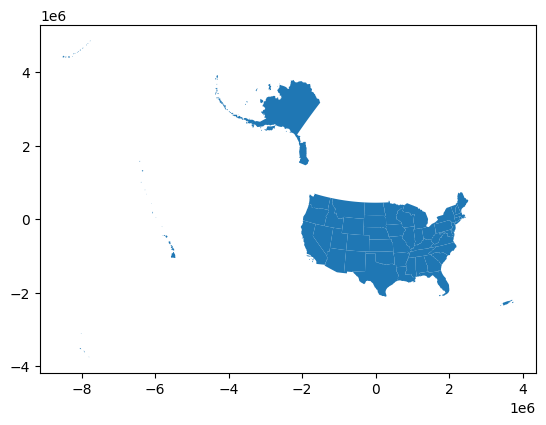

In [ ]:
# Plot raw state boundaries
df_states.plot()

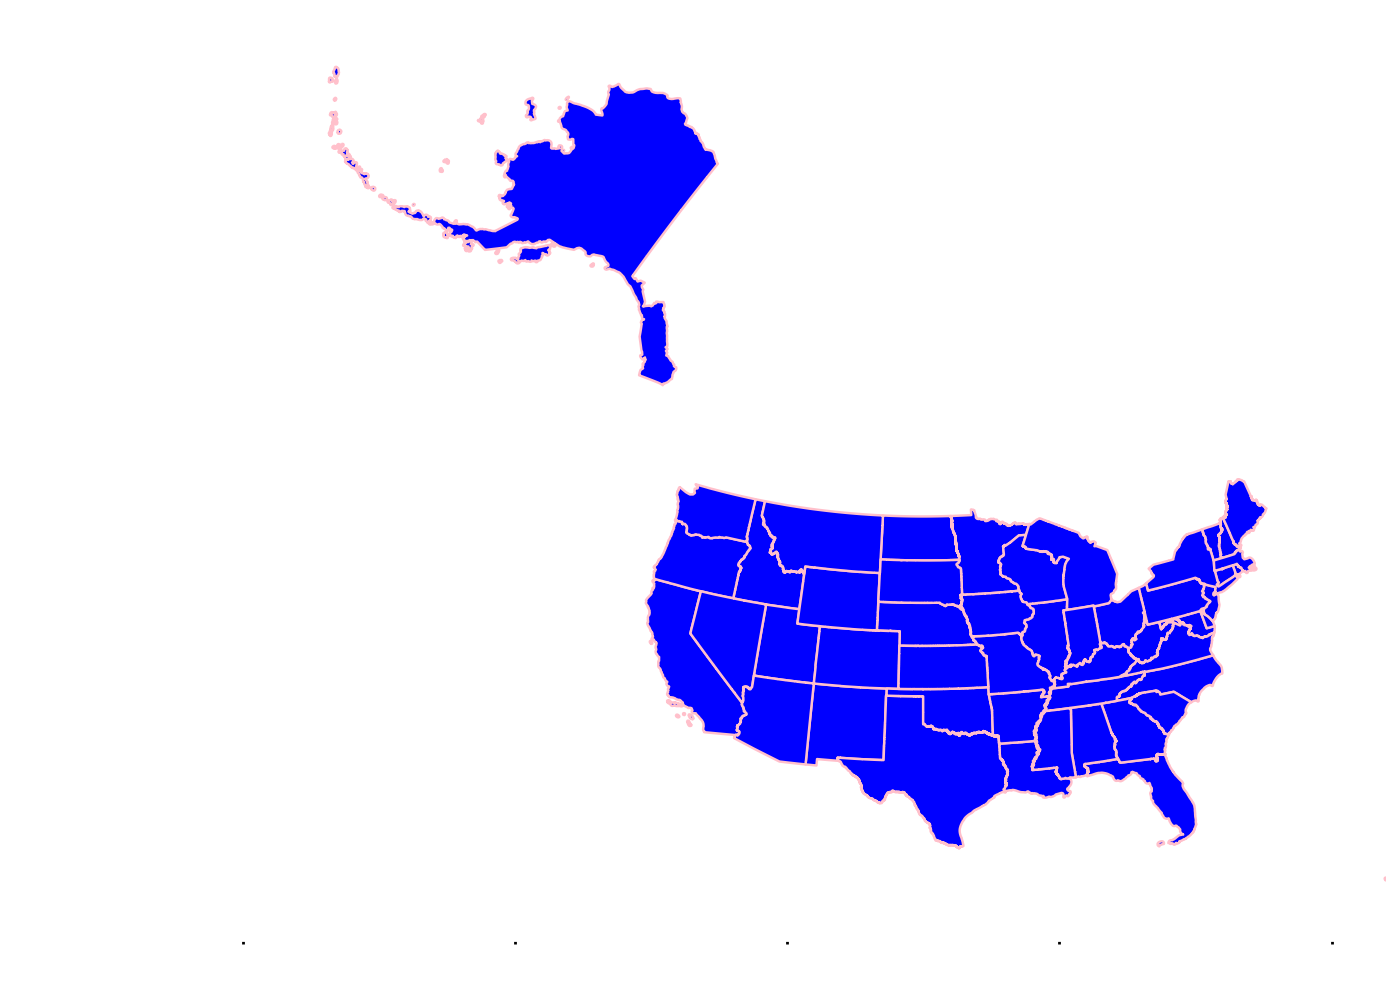

In [ ]:
# Plot raw state boundaries
plotnine.options.figure_size = (7, 5)


(
 ggplot()
  + geom_map(df_states, fill='blue', color='pink')
  + xlim(-5e6,3e6)
  + ylim(-2.5e6, 4e6)
  + theme_classic()
  + theme(axis_line=element_line(color="white"),
          axis_ticks=element_line(color = "white"),
          axis_text=element_line(color='white'),
          text=element_text(size = 12))
 )

# # Merge insect dataset with state geometries
- Using left join to merge the two datasets

In [ ]:
# Check unique state names
df_states["NAME"].unique()

array(['West Virginia', 'Florida', 'Illinois', 'Minnesota', 'Maryland',
       'Rhode Island', 'Idaho', 'New Hampshire', 'North Carolina',
       'Vermont', 'Connecticut', 'Delaware', 'New Mexico', 'California',
       'New Jersey', 'Wisconsin', 'Oregon', 'Nebraska', 'Pennsylvania',
       'Washington', 'Louisiana', 'Georgia', 'Alabama', 'Utah', 'Ohio',
       'Texas', 'Colorado', 'South Carolina', 'Oklahoma', 'Tennessee',
       'Wyoming', 'Hawaii', 'North Dakota', 'Kentucky',
       'United States Virgin Islands',
       'Commonwealth of the Northern Mariana Islands', 'Guam', 'Maine',
       'New York', 'Nevada', 'Alaska', 'American Samoa', 'Michigan',
       'Arkansas', 'Mississippi', 'Missouri', 'Montana', 'Kansas',
       'Indiana', 'Puerto Rico', 'South Dakota', 'Massachusetts',
       'Virginia', 'District of Columbia', 'Iowa', 'Arizona'],
      dtype=object)

In [ ]:
# nunique NAME
df_states["NAME"].nunique()

56

In [ ]:
# merging
merged_data = pd.merge(insect_data, df_states, how='left', left_on='stateProvince', right_on='NAME')

In [ ]:
merged_data.head()

,year,stateProvince,total_richness,total_abundance,Lepidoptera_richness,Lepidoptera_abundance,Hymenoptera_richness,Hymenoptera_abundance,Coleoptera_richness,Coleoptera_abundance,...,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,1901,Alaska,1,1,1.0,1.0,NaN,NaN,NaN,NaN,...,AK,Alaska,00,G4000,A,1.478941e+12,2.453802e+11,+63.3473560,-152.8397334,"MULTIPOLYGON (((-2996338.494 3218001.01, -2996..."
1,1901,Arizona,1,1,1.0,1.0,NaN,NaN,NaN,NaN,...,AZ,Arizona,00,G4000,A,2.943610e+11,8.588533e+08,+34.2039362,-111.6063449,"POLYGON ((-1352675.805 -1213409.363, -1352687...."
2,1901,California,4,6,1.0,2.0,NaN,NaN,3.0,4.0,...,CA,California,00,G4000,A,4.036712e+11,2.029413e+10,+37.1551773,-119.5434183,"MULTIPOLYGON (((-1976113.896 -98951.979, -1976..."
3,1901,Colorado,2,3,1.0,1.0,NaN,NaN,1.0,2.0,...,CO,Colorado,00,G4000,A,2.684187e+11,1.185766e+09,+38.9937669,-105.5087122,"POLYGON ((-767148.887 -489022.412, -767062.794..."
4,1901,Connecticut,7,7,6.0,6.0,NaN,NaN,1.0,1.0,...,CT,Connecticut,00,G4000,A,1.254169e+10,1.816426e+09,+41.5798637,-072.7466572,"POLYGON ((2153173.583 -17591.487, 2153172.248 ..."


In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4175 entries, 0 to 4174
Data columns (total 89 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   year                         4175 non-null   int64   
 1   stateProvince                4175 non-null   object  
 2   total_richness               4175 non-null   int64   
 3   total_abundance              4175 non-null   int64   
 4   Lepidoptera_richness         3872 non-null   float64 
 5   Lepidoptera_abundance        3872 non-null   float64 
 6   Hymenoptera_richness         741 non-null    float64 
 7   Hymenoptera_abundance        741 non-null    float64 
 8   Coleoptera_richness          1021 non-null   float64 
 9   Coleoptera_abundance         1021 non-null   float64 
 10  Diptera_richness             668 non-null    float64 
 11  Diptera_abundance            668 non-null    float64 
 12  Odonata_richness             305 non-null    float64 
 13  Odo

# Mapping

Note:
- Plotnine has limitations when plotting geometries directly, as it expects separate X and Y columns.
- Since our state boundaries are stored as full polygon geometries, we will use Matplotlib instead for mapping.

# Calculate mean richness and abundance per state

In [ ]:
# State-level mean total richness
state_richness = merged_data.groupby('stateProvince', as_index=False)['total_richness'].mean()

In [ ]:
state_richness.head()

,stateProvince,total_richness
0,Alabama,4.081081
1,Alaska,4.245283
2,Arizona,26.061947
3,Arkansas,3.297872
4,California,63.474576


### Merge state_richness with merged_data, and plot

In [ ]:
# Prepare merged map data
map_data = pd.merge(state_richness, merged_data[['stateProvince', 'geometry']], on='stateProvince', how='left').drop_duplicates('stateProvince')

In [ ]:
# Group by stateProvince and aggregate richness
state_richness = merged_data.groupby('stateProvince')[['total_richness']].mean().reset_index()

In [ ]:
# Merge with geometry to make it plottable
map_df = pd.merge(state_richness, merged_data[['stateProvince', 'geometry']], on='stateProvince', how='left').drop_duplicates(subset='stateProvince')

In [ ]:
# Convert map_df to GeoDataFrame
map_gdf = gpd.GeoDataFrame(map_df, geometry='geometry')

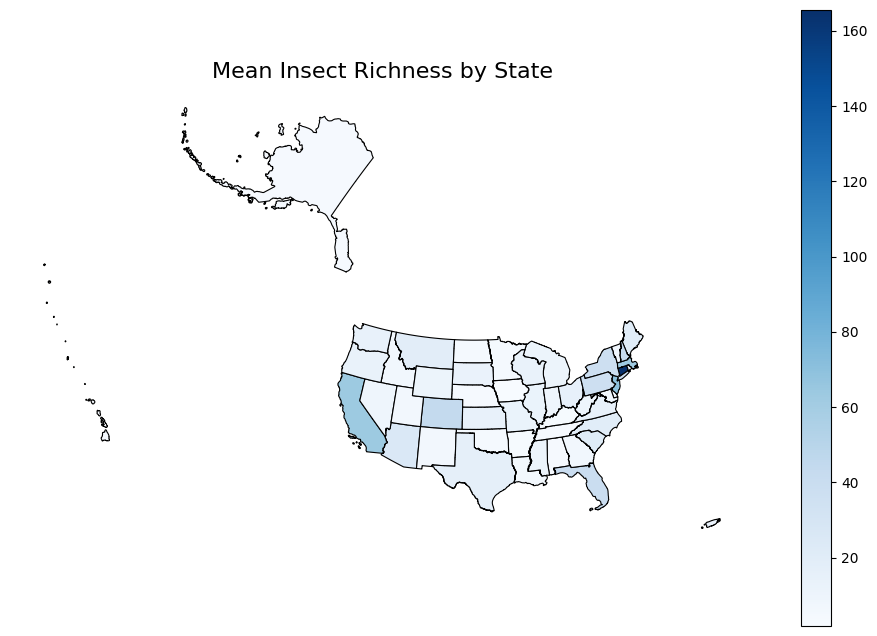

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(12, 8))
map_gdf.plot(column='total_richness', cmap='Blues', linewidth=0.8, edgecolor='black', legend=True, ax=ax)
ax.set_title('Insect Richness by State (Mean)', fontsize=16)
ax.axis('off')
plt.show()


### Comments:

- The map of mean insect richness by state reveals notable geographic variation in recorded insect diversity across the United States. States like California and New York exhibit the highest richness, likely reflecting both true biodiversity hotspots and the influence of greater sampling efforts associated with major research institutions.

- Moderate richness is observed in parts of the Southwest, Florida, and the Mid-Atlantic, while much of the Midwest and interior South shows lower richness levels.

- However, these patterns should be interpreted cautiously. We suspect Sampling Bias as the data are based on museum collections and  Museums and researchers may have collected more insect specimens in places like California and New York due to more research institutions, better infrastructure, or historical projects.

- Thus, this map shows observed richness (based on museum data), not true natural richness. Correcting for sampling effort would be necessary to assess true insect biodiversity across states more accurately.

## Map Nymphalidae richness and abundance
* Repeating similar steps above

### Nymphalidae richness

In [ ]:
state_Nymphalidae  = merged_data.groupby('stateProvince', as_index=False)['Nymphalidae_richness'].mean()

In [ ]:
geometry_map = merged_data[['stateProvince', 'geometry']].drop_duplicates('stateProvince')
nymph_map = pd.merge(state_Nymphalidae, geometry_map, on='stateProvince', how='left')

In [ ]:
nymph_gdf = gpd.GeoDataFrame(nymph_map, geometry='geometry')

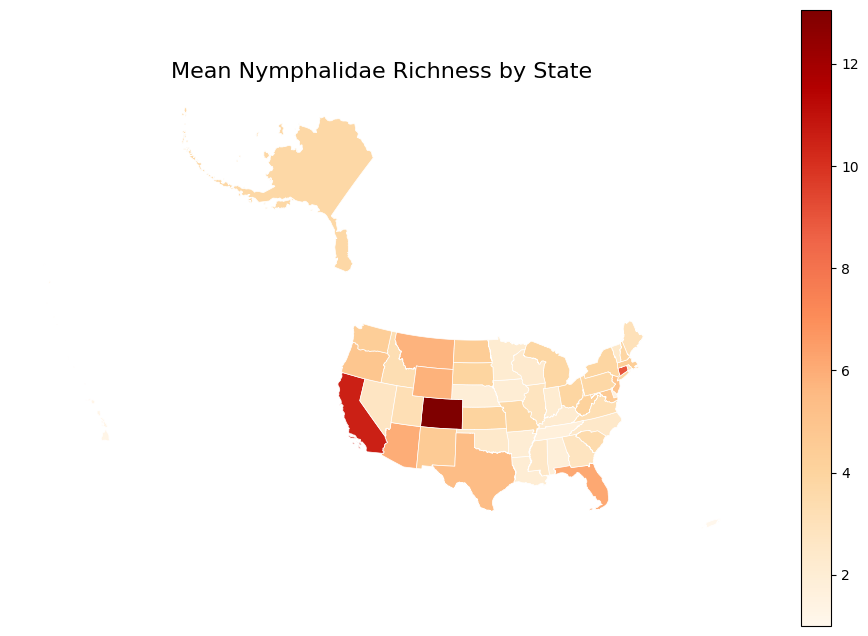

In [ ]:
# plot
fig, ax = plt.subplots(figsize=(12, 8))
nymph_gdf.plot(
    column='Nymphalidae_richness',
    cmap='OrRd',
    linewidth=0.5,
    edgecolor='white',
    legend=True,
    ax=ax
)
ax.set_title('Nymphalidae Richness by State (Mean)', fontsize=16)
ax.axis('off')
plt.show()

### Comments:

- The map of mean Nymphalidae richness by state highlights a different pattern compared to total insect richness. California and Colorado stand out with the highest recorded Nymphalidae diversity, with California expected due to its biodiversity but Colorado's peak possibly reflecting sampling concentration rather than true ecological richness. Most other states show low to moderate richness levels.

- As with total richness, caution is needed because museum collection biases likely influence the observed patterns.

## **Mapping Nymph_abundance**

In [ ]:
state_nymph_abund = merged_data.groupby('stateProvince', as_index=False)['Nymphalidae_abundance'].mean()

In [ ]:
geometry_map = merged_data[['stateProvince', 'geometry']].drop_duplicates('stateProvince')

In [ ]:
nymph_abund_map = pd.merge(state_nymph_abund, geometry_map, on='stateProvince', how='left')

In [ ]:
nymph_abund_gdf = gpd.GeoDataFrame(nymph_abund_map, geometry='geometry')

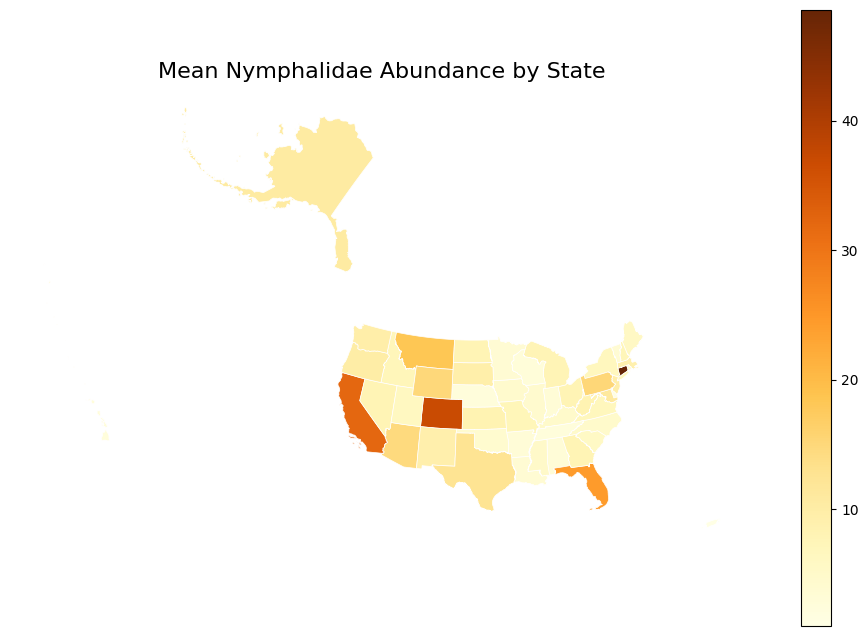

In [ ]:
#plotting
fig, ax = plt.subplots(figsize=(12, 8))
nymph_abund_gdf.plot(
    column='Nymphalidae_abundance',
    cmap='YlOrBr',
    linewidth=0.5,
    edgecolor='white',
    legend=True,
    ax=ax
)
ax.set_title('Nymphalidae Abundance by State (Mean)', fontsize=16)
ax.axis('off')
plt.show()

### Comments:

- The map of mean Nymphalidae abundance by state mirrors the richness pattern, with California and Colorado again showing the highest recorded abundance levels. This suggests that not only are more Nymphalidae species recorded in these states, but also that individual collection counts are higher there. However, as with richness, collection intensity likely influences these patterns, and true abundance across states may differ from what museum records show.

##  Map total abundance (all insects)

In [ ]:
state_abund = merged_data.groupby('stateProvince', as_index=False)['total_abundance'].mean()

In [ ]:
geometry_map = merged_data[['stateProvince', 'geometry']].drop_duplicates('stateProvince')

In [ ]:
abund_map = pd.merge(state_abund, geometry_map, on='stateProvince', how='left')

In [ ]:
abund_gdf = gpd.GeoDataFrame(abund_map, geometry='geometry')

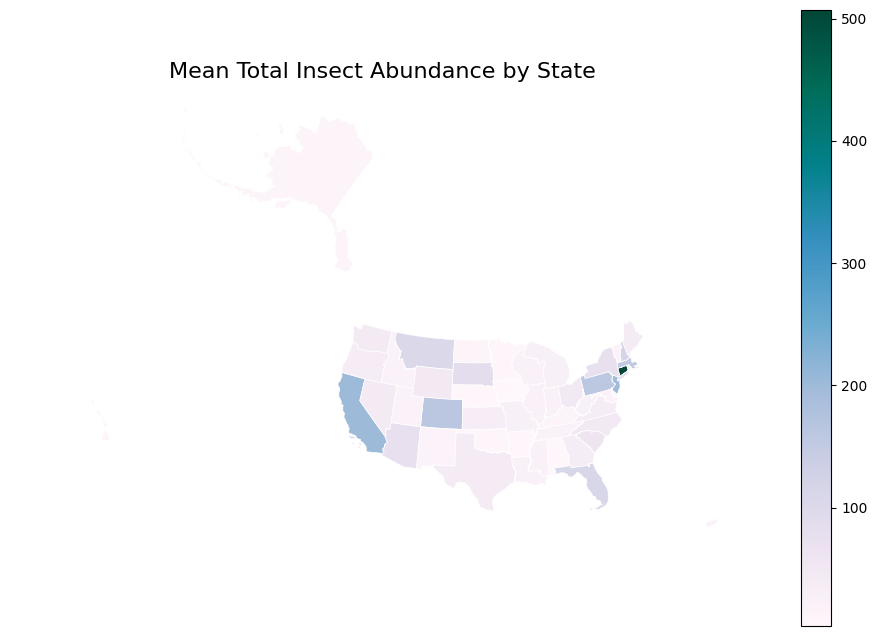

In [ ]:
#plotting
fig, ax = plt.subplots(figsize=(12, 8))

abund_gdf.plot(
    column='total_abundance',
    cmap='PuBuGn',
    linewidth=0.5,
    edgecolor='white',
    legend=True,
    ax=ax
)
ax.set_title('Total Insect Abundance by State (Mean)', fontsize=16)
ax.axis('off')
plt.show()


## Comments:

- The map of mean total insect abundance by state shows a strong dominance of the Northeast (especially New York) and California, where collection counts are highest. These patterns largely reflect where insect sampling has been most intense rather than true insect population densities, highlighting the need to account for sampling effort when interpreting abundance metrics.

# Log-transformed maps for better visualization
* Log-transform abundance to reduce the effect of extreme values
* This helps visualize differences between states more clearly
* Especially when a few states have much higher insect counts than others.
* We use log1p (log(1 + x)) to safely handle zero values.

## Simply
 - Purpose: log-transform to reduce impact of extreme outliers
 - Safe method: log(1+x) to avoid issues with zeros


##  Log-transformed total abundance

In [ ]:
#Group and log-transform total_abundance
state_abund = merged_data.groupby('stateProvince', as_index=False)['total_abundance'].mean()
state_abund['log_total_abundance'] = np.log1p(state_abund['total_abundance'])  # log(1 + x) to avoid log(0)

In [ ]:
# Merge with and covert to geometry
geometry_map = merged_data[['stateProvince', 'geometry']].drop_duplicates('stateProvince')
abund_map = pd.merge(state_abund, geometry_map, on='stateProvince', how='left')
abund_gdf = gpd.GeoDataFrame(abund_map, geometry='geometry')


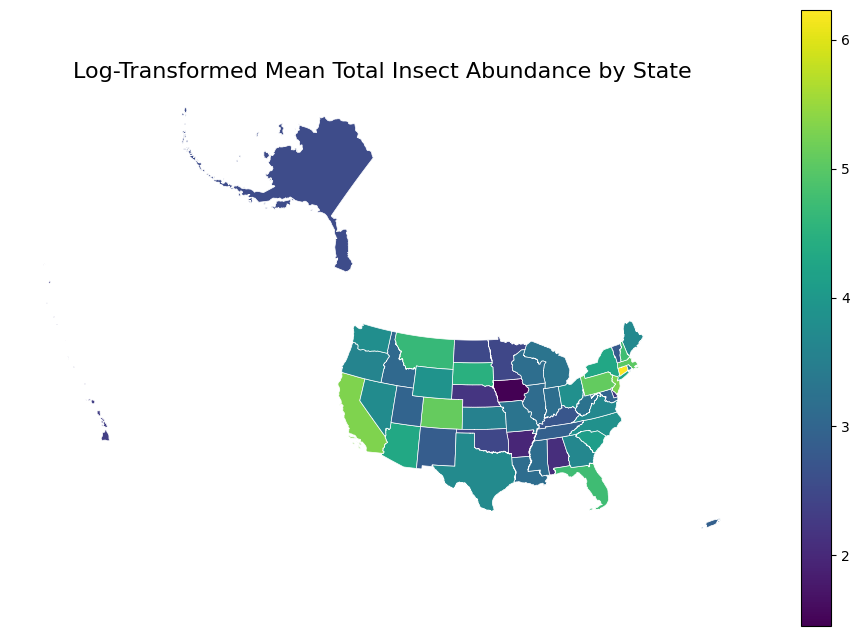

In [ ]:
# plotting
fig, ax = plt.subplots(figsize=(12, 8))
abund_gdf.plot(
    column='log_total_abundance',
    cmap='viridis',
    linewidth=0.5,
    edgecolor='white',
    legend=True,
    ax=ax
)
ax.set_title('Total Insect Abundance by State (Log)', fontsize=16)
ax.axis('off')
plt.show()

### Comments:

- Applying a log transformation to mean total insect abundance reveals a more balanced distribution across states, reducing the visual dominance of a few heavily sampled regions like New York and California. Previously hidden differences among low- to mid-abundance states now become visible.

- For example: states like North Carolina, Texas, and Florida now show up with intermediate colors, highlighting that they had meaningful (though not extreme) collection efforts.

- While these states still stand out, other states become more comparable, allowing a clearer view of relative differences in collection intensity. However, underlying sampling biases still affect interpretation.

### Log-Transformed Total Richness Map

In [ ]:
# Mean richness per state
state_rich = merged_data.groupby('stateProvince', as_index=False)['total_richness'].mean()

In [ ]:
# Log-transform it
state_rich['log_total_richness'] = np.log1p(state_rich['total_richness'])

In [ ]:
# Merge with geometries
geometry_map = merged_data[['stateProvince', 'geometry']].drop_duplicates('stateProvince')
rich_map = pd.merge(state_rich, geometry_map, on='stateProvince', how='left')

In [ ]:
#Convert to GeoDataFrame
rich_gdf = gpd.GeoDataFrame(rich_map, geometry='geometry')

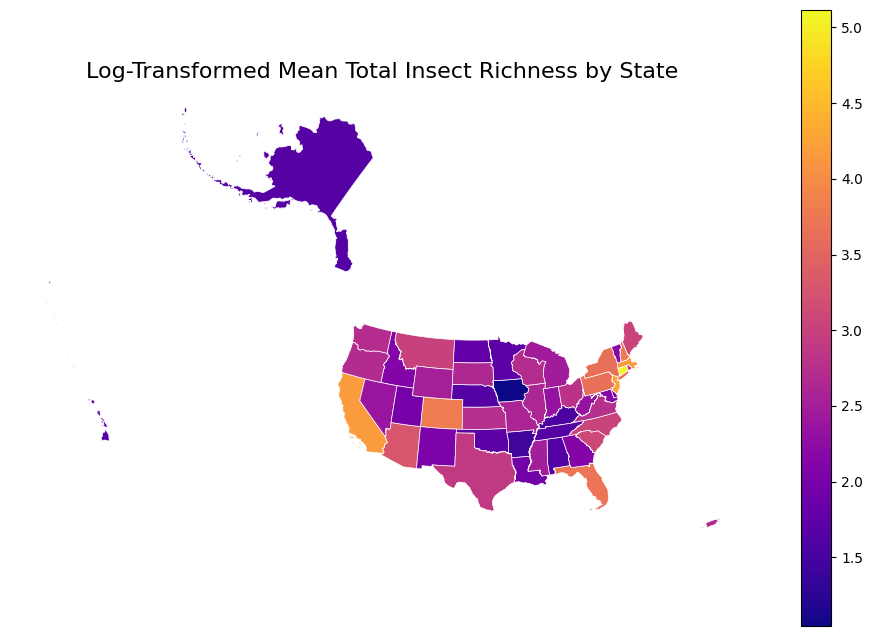

In [ ]:
# Plotting

fig, ax = plt.subplots(figsize=(12, 8))

rich_gdf.plot(
    column='log_total_richness',
    cmap='plasma',
    linewidth=0.5,
    edgecolor='white',
    legend=True,
    ax=ax
)
ax.set_title('Average Total Insect Richness by State (Log)', fontsize=16)
ax.axis('off')
plt.show()

### Comments:

- The log-transformed mean insect richness map reveals a more balanced spread of diversity across states, making mid-range richness states like Colorado, Texas, and Florida stand out more clearly. California and New York still show the highest richness levels, but other states with meaningful insect diversity, such as Arizona and North Carolina, are now visibly distinct from states with very low richness.

- Without transformation, these differences were largely invisible because of the overwhelming dominance of a few high-richness states. The log scale thus highlights a broader and more interpretable distribution of insect richness across the U.S.



## Log of Nymphalidae Abundance by State

In [ ]:
# Group by state and calculate mean abundance
state_nymph = merged_data.groupby('stateProvince', as_index=False)['Nymphalidae_abundance'].mean()

In [ ]:
# Log-transform
state_nymph['log_Nymphalidae_abundance'] = np.log1p(state_nymph['Nymphalidae_abundance'])

In [ ]:
# Merge with geometries
geometry_map = merged_data[['stateProvince', 'geometry']].drop_duplicates('stateProvince')
nymph_map = pd.merge(state_nymph, geometry_map, on='stateProvince', how='left')

In [ ]:
#Convert to GeoDataFrame
nymph_gdf = gpd.GeoDataFrame(nymph_map, geometry='geometry')

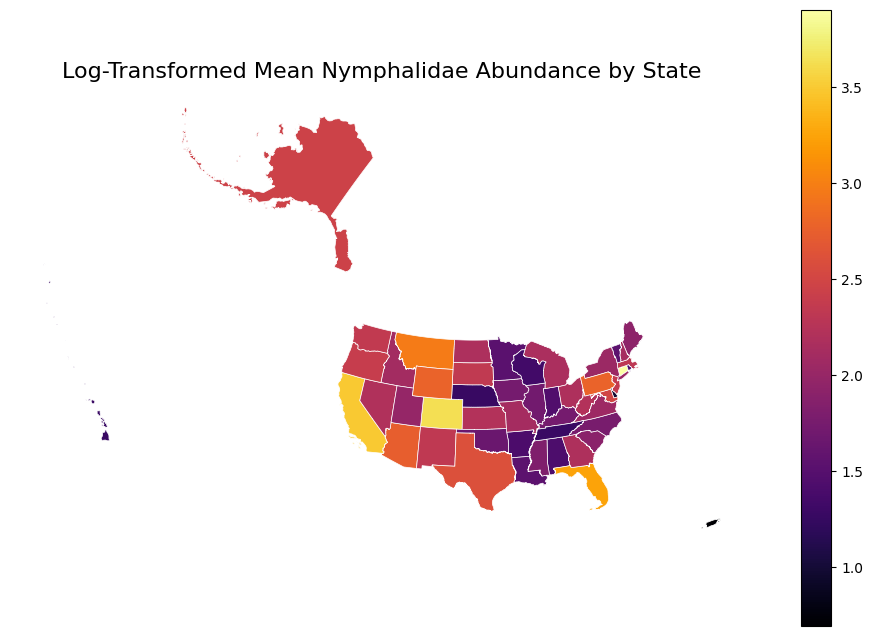

In [ ]:
#Plotting

fig, ax = plt.subplots(figsize=(12, 8))

nymph_gdf.plot(
    column='log_Nymphalidae_abundance',
    cmap='inferno',
    linewidth=0.5,
    edgecolor='white',
    legend=True,
    ax=ax
)
ax.set_title('Average Nymphalidae Abundance by State (Log)', fontsize=16)
ax.axis('off')
plt.show()

### Comments:

- The log-transformed map of mean Nymphalidae abundance reveals a much smoother distribution across states compared to the raw abundance map. California and Colorado remain the top states, but the transformation highlights that other states like Arizona, New Mexico, and Texas also have notable Nymphalidae collections, which were previously overshadowed.

- In contrast, much of the Midwest and the Southeast continues to show relatively lower abundance levels even after transformation, suggesting a real difference rather than just a sampling artifact.